## Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

# Подготовка данных

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt



import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.mllib.linalg import DenseMatrix, Vectors
from pyspark.sql.functions import isnan, when, count, col


from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator
        
RANDOM_SEED = 12345



In [2]:
# инициируем Spark сессию и загружаем данные
spark = SparkSession.builder \
                    .master("local") \
                    .appName("median_house_value - Linear Regression") \
                    .getOrCreate()

df = spark.read.option('header', 'true').csv('/datasets/housing.csv', inferSchema = True)


In [3]:
# выводим схему данных
df.printSchema()
df.show(5)

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR B

In [4]:
# количество строк данных
df.select('median_house_value').count()

20640

In [5]:
# удаляем ненужные столбцы 
df = df.drop('longitude', 'latitude') 

In [6]:
# находим столбцы с пропущенными значениями
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()



+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|                 0|          0|           207|         0|         0|            0|                 0|              0|
+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



In [12]:
# разделяем наш датасет на две части выборку для обучения и выборку для тестирования 
train_data, test_data = df.randomSplit([.7,.3], seed=RANDOM_SEED)
print(train_data.count(), test_data.count())


14371 6269


In [13]:
# функция для замены медианным значением пропусков в обучающих данных
def imputer_1(df):
    median = ['total_bedrooms']
    imputer = Imputer(
        inputCols=median,
        outputCols=["{}_with_median".format(c) for c in median]
    ).setStrategy("median")
    result = imputer.fit(df).transform(df)
    result.show(5, truncate=False)
    return result

In [14]:
# вызываем функцию 
result = imputer_1(train_data)

+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+--------------------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|total_bedrooms_with_median|
+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+--------------------------+
|1.0               |6.0        |2.0           |8.0       |2.0       |1.625        |55000.0           |INLAND         |2.0                       |
|1.0               |83.0       |15.0          |32.0      |15.0      |4.875        |141700.0          |INLAND         |15.0                      |
|1.0               |2062.0     |343.0         |872.0     |268.0     |5.2636       |191300.0          |INLAND         |343.0                     |
|1.0               |2254.0     |328.0         |402.0     |112.0     |4.25         |189200.0          |INLAND         |328.0 

In [15]:
# удаляем столбец с пропусками в обучающей выборке
result = result.drop('total_bedrooms')

In [16]:
# проверяем пропуски в обучающих данных
result.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in result.columns]).show()



+------------------+-----------+----------+----------+-------------+------------------+---------------+--------------------------+
|housing_median_age|total_rooms|population|households|median_income|median_house_value|ocean_proximity|total_bedrooms_with_median|
+------------------+-----------+----------+----------+-------------+------------------+---------------+--------------------------+
|                 0|          0|         0|         0|            0|                 0|              0|                         0|
+------------------+-----------+----------+----------+-------------+------------------+---------------+--------------------------+



In [17]:
# функция для замены медианным значением пропусков в тестовых данных
def imputer_2(df):
    median = ['total_bedrooms']
    imputer = Imputer(
        inputCols=median,
        outputCols=["{}_with_median".format(c) for c in median]
    ).setStrategy("median")
    result = imputer.fit(train_data)
    result2 = result.transform(df)
    result2.show(5, truncate=False)
    return result2

In [18]:
# вызываем функцию 
result2 = imputer_2(test_data)

+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+--------------------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|total_bedrooms_with_median|
+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+--------------------------+
|2.0               |200.0      |20.0          |25.0      |9.0       |15.0001      |350000.0          |<1H OCEAN      |20.0                      |
|2.0               |790.0      |135.0         |235.0     |87.0      |5.0862       |166500.0          |INLAND         |135.0                     |
|2.0               |1205.0     |468.0         |577.0     |363.0     |3.6437       |275000.0          |NEAR BAY       |468.0                     |
|2.0               |2239.0     |321.0         |766.0     |219.0     |5.75         |240200.0          |INLAND         |321.0 

In [19]:
# удаляем столбец с пропусками в тестовой выборке
result2 = result2.drop('total_bedrooms')

In [20]:
# проверяем столбцы на пропущенные значения
result2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in result2.columns]).show()



+------------------+-----------+----------+----------+-------------+------------------+---------------+--------------------------+
|housing_median_age|total_rooms|population|households|median_income|median_house_value|ocean_proximity|total_bedrooms_with_median|
+------------------+-----------+----------+----------+-------------+------------------+---------------+--------------------------+
|                 0|          0|         0|         0|            0|                 0|              0|                         0|
+------------------+-----------+----------+----------+-------------+------------------+---------------+--------------------------+



In [21]:
# возращаем данным знакомые имена
train_data = result
test_data = result2

In [22]:
# добавим столбцы нужные для модели
train_data = train_data.withColumn('rooms_per_household', F.col('total_rooms') / F.col('households'))
train_data = train_data.withColumn('population_in_household', F.col('population') / F.col('households'))
train_data = train_data.withColumn('bedroom_index', F.col('total_bedrooms_with_median') / F.col('total_rooms'))

test_data = test_data.withColumn('rooms_per_household', F.col('total_rooms') / F.col('households'))
test_data = test_data.withColumn('population_in_household', F.col('population') / F.col('households'))
test_data = test_data.withColumn('bedroom_index', F.col('total_bedrooms_with_median') / F.col('total_rooms'))



In [23]:
train_data.limit(3).toPandas()

,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity,total_bedrooms_with_median,rooms_per_household,population_in_household,bedroom_index
0,1.0,6.0,8.0,2.0,1.6250,55000.0,INLAND,2.0,3.000000,4.000000,0.333333
1,1.0,83.0,32.0,15.0,4.8750,141700.0,INLAND,15.0,5.533333,2.133333,0.180723
2,1.0,2062.0,872.0,268.0,5.2636,191300.0,INLAND,343.0,7.694030,3.253731,0.166343


In [24]:
# удаляем категорийный столбец для вывода корреляции коэффициента Пирсона
df2 = train_data.drop('ocean_proximity')


In [25]:
# конвертируем в вектор числовые столбцы
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df2.columns, outputCol=vector_col)
df_vector = assembler.transform(df2).select(vector_col)


23/05/16 17:05:43 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/05/16 17:05:43 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


<AxesSubplot:>

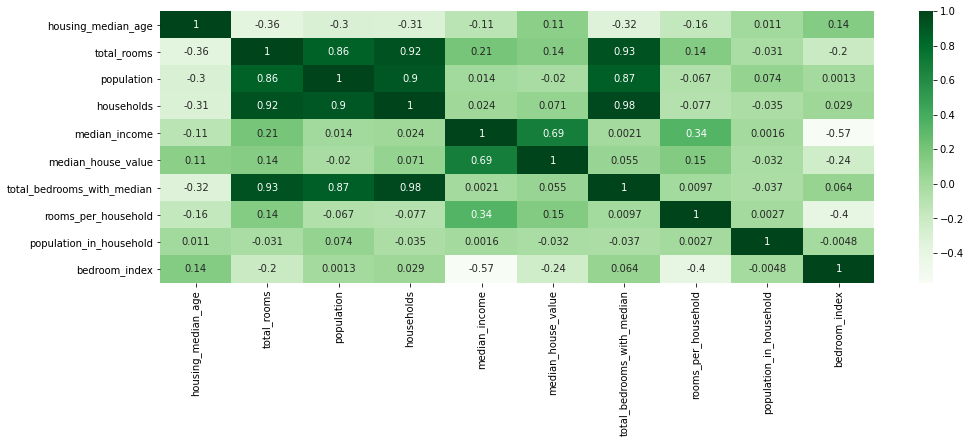

In [26]:
# визуализируем матрицу корреляций коэффициента Пирсона
matrix = Correlation.corr(df_vector, "corr_features").collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns =df2.columns, index=df2.columns) 

plt.figure(figsize=(16,5))  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)

# corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)



In [27]:
# оставим столбцы с корреляцией к стобцу 'median_house_value' более 0.1 
train_data = train_data.drop(
    'population', 'households', 'total_bedrooms_with_median', 'population_in_household')

test_data = test_data.drop(
    'population', 'households', 'total_bedrooms_with_median', 'population_in_household')



In [28]:
train_data.show(3)
train_data.printSchema()

+------------------+-----------+-------------+------------------+---------------+-------------------+-------------------+
|housing_median_age|total_rooms|median_income|median_house_value|ocean_proximity|rooms_per_household|      bedroom_index|
+------------------+-----------+-------------+------------------+---------------+-------------------+-------------------+
|               1.0|        6.0|        1.625|           55000.0|         INLAND|                3.0| 0.3333333333333333|
|               1.0|       83.0|        4.875|          141700.0|         INLAND|  5.533333333333333|0.18072289156626506|
|               1.0|     2062.0|       5.2636|          191300.0|         INLAND| 7.6940298507462686|0.16634335596508246|
+------------------+-----------+-------------+------------------+---------------+-------------------+-------------------+
only showing top 3 rows

root
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- median_income: dou

In [29]:
# median_house_value - целевая переменная
target = "median_house_value" 
stages = []

# предобработка категорийного  категориальной колонки в бинарные вектора благодаря строковому преобразователю
categoricalColumns = ['ocean_proximity']
for categoricalCol in categoricalColumns:
    
    stringIndexer = StringIndexer(inputCol = categoricalCol,
                                 outputCol = 'ocean_proximity_Ind', handleInvalid = 'keep')
    
    encoder = OneHotEncoder(inputCol='ocean_proximity_Ind',
                            outputCol='ocean_proximity_ohe')
        
    stages += [stringIndexer, encoder]
    
    
numericColumns = ["housing_median_age", "total_rooms",
                   "median_income", "rooms_per_household", "bedroom_index"]

all_features = ['ocean_proximity_ohe'] + numericColumns

# преобразование нескольких колонок в вектор-колонку - признаки
final_assembler = VectorAssembler(inputCols=all_features, outputCol="features") 

stages += [final_assembler]



# Обучение моделей

In [30]:
# обучение модели линейной регрессии
lr = LinearRegression(
    labelCol=target, featuresCol='features', maxIter=10, regParam=0.3, elasticNetParam=0.8)
stages += [lr]


In [31]:
# задаем план stages для обучения модели 
pipeline = Pipeline(stages=stages)

In [32]:
# тренируем модель на обучающей выборке
model = pipeline.fit(train_data)


In [33]:
# делаем предсказания на тестовой выборке
predictions = model.transform(test_data)

In [34]:
# выводим предсказания модели
predictedLabes = predictions.select("median_house_value", "prediction")
predictedLabes.show() 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          350000.0| 638710.6603320944|
|          166500.0|166564.61781760005|
|          275000.0| 234070.6422985208|
|          240200.0|194187.12647185745|
|          331400.0| 345811.0246344701|
|          158500.0|221153.52221256084|
|          214500.0|208201.50750609682|
|          144400.0|156855.86561019687|
|          181000.0|228797.77616813596|
|          167800.0|241344.89402662052|
|          111300.0| 141173.3529489548|
|          175000.0|294126.35447499575|
|           92500.0|115662.27897039699|
|          271400.0|282968.01069104124|
|          206300.0|193669.94525570588|
|          467600.0|406440.27333450667|
|          136400.0| 225627.5730786509|
|          251800.0|220760.65028819148|
|          191900.0| 197802.6210390813|
|          140800.0| 159948.8462718827|
+------------------+------------------+
only showing top 20 rows



In [35]:
# оценим качество модели по всем данным по заданным метрикам
evaluator = RegressionEvaluator(labelCol='median_house_value',
                             predictionCol='prediction' , metricName='rmse')
predicted_df = model.transform(test_data)
rmse= evaluator.evaluate(predicted_df)

evaluator = RegressionEvaluator(labelCol='median_house_value',
                             predictionCol='prediction' , metricName='mae')
predicted_df = model.transform(test_data)
mae = evaluator.evaluate(predicted_df)

evaluator = RegressionEvaluator(labelCol='median_house_value',
                             predictionCol='prediction' , metricName='r2')
predicted_df = model.transform(test_data)
r2 = evaluator.evaluate(predicted_df)

print("RMSE: %f" % rmse)
print("MAE: %f" % mae)
print("r2: %f" % r2)



RMSE: 73713.406219
MAE: 52746.654759
r2: 0.596710


In [36]:
# median_house_value - целевая переменная
target = "median_house_value" 
stages = []


numericColumns = ["housing_median_age", "total_rooms",
                   "median_income", "rooms_per_household", "bedroom_index"]

all_features = numericColumns

# преобразование нескольких колонок в вектор-колонку - признаки
final_assembler = VectorAssembler(inputCols=all_features, outputCol="features2") 

stages += [final_assembler]



In [37]:
# обучение модели линейной регрессии без категориальных переменных
lr2 = LinearRegression(
    labelCol=target, featuresCol='features2', maxIter=10, regParam=0.3, elasticNetParam=0.8)
stages += [lr2]


In [38]:
# задаем план stages для обучения модели 
pipeline = Pipeline(stages=stages)

In [39]:
# тренируем модель на обучающей выборке
model2 = pipeline.fit(train_data)


In [40]:
# делаем предсказания на тестовой выборке
predictions = model2.transform(test_data)

In [41]:
# выводим предсказания модели без категориальных переменных
predictedLabes = predictions.select("median_house_value", "prediction")
predictedLabes.show() 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          350000.0| 635546.6391739781|
|          166500.0|188470.94452791393|
|          275000.0|211087.99529022397|
|          240200.0|215897.74827306625|
|          331400.0|319723.71073502034|
|          158500.0| 168998.5139363596|
|          214500.0|153083.07391523826|
|          144400.0|180947.59963920934|
|          181000.0| 264551.8711529937|
|          167800.0| 219115.4291164549|
|          111300.0|165853.92828567262|
|          175000.0|258983.27227455942|
|           92500.0|149742.07445821306|
|          271400.0| 267595.9244995236|
|          206300.0|226485.34092075587|
|          467600.0|380886.29936252616|
|          136400.0|191328.23225499067|
|          251800.0|258280.18255952286|
|          191900.0|228773.56493036024|
|          140800.0|191992.79696068948|
+------------------+------------------+
only showing top 20 rows



In [42]:
# оценим качество модели без категориальных переменных по заданным метрикам
evaluator = RegressionEvaluator(labelCol='median_house_value',
                             predictionCol='prediction' , metricName='rmse')
predicted_df = model2.transform(test_data)
rmse2= evaluator.evaluate(predicted_df)

evaluator = RegressionEvaluator(labelCol='median_house_value',
                             predictionCol='prediction' , metricName='mae')
predicted_df = model2.transform(test_data)
mae2 = evaluator.evaluate(predicted_df)

evaluator = RegressionEvaluator(labelCol='median_house_value',
                             predictionCol='prediction' , metricName='r2')
predicted_df = model2.transform(test_data)
r2_2 = evaluator.evaluate(predicted_df)

print("RMSE: %f" % rmse2)
print("MAE: %f" % mae2)
print("r2: %f" % r2_2)



RMSE: 81097.491594
MAE: 58068.517936
r2: 0.511866


# Анализ результатов

In [43]:
print("Метрики оценки модели с категориальными переменными: ")
print("RMSE: %f" % rmse)
print("MAE: %f" % mae)
print("r2: %f" % r2)

Метрики оценки модели с категориальными переменными: 
RMSE: 73713.406219
MAE: 52746.654759
r2: 0.596710


In [44]:
print("Метрики оценки модели без категориальных переменных: ")
print("RMSE: %f" % rmse2)
print("MAE: %f" % mae2)
print("r2: %f" % r2_2)

Метрики оценки модели без категориальных переменных: 
RMSE: 81097.491594
MAE: 58068.517936
r2: 0.511866


In [45]:
spark.stop()

### Вывод

По результату исследования модель с категориальными переменными показала лучшие показатели, хотя модель далека от идеальной. При выборе из двух модели, выберем модель с категориальными переменными.